In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabin have a ot of Nan values, we will drop this column
We will replace Age Nan values with the age's median and the ones in embarked with'S', which are the most frequent 

In [5]:
df_train.drop('Cabin',axis=1,inplace=True)
df_train["Age"].fillna(df_train['Age'].median(),inplace=True)
df_train['Embarked'].fillna("S",inplace=True)
df_train['Fare'].fillna(df_train['Fare'].mean(), inplace=True)


df_test.drop('Cabin',axis=1,inplace=True)
df_test["Age"].fillna(df_test['Age'].median(),inplace=True)
df_test['Embarked'].fillna("S",inplace=True)
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)


### Visualization

Convert values to categorical (especially Sex)

In [6]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [7]:
df_train['Sex'] = pd.Categorical(df_train['Sex']).codes
df_train['Embarked'] = pd.Categorical(df_train['Embarked']).codes

df_test['Sex'] = pd.Categorical(df_test['Sex']).codes
df_test['Embarked'] = pd.Categorical(df_test['Embarked']).codes

function to plot survival against passenger attribute

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def survival_rate(column,t):
    df = pd.DataFrame()
    df['total'] = df_train.groupby(column).size()
    df['Survived'] = df_train.groupby(column).sum()['Survived']
    df['percentage'] = round(df['Survived']/df['total']*100,2)
    #print(df_train)
    
    df['Survived'].plot(kind=t)
    df['total'].plot(kind=t,alpha=0.5, title="Survivors per" +str(column))
    plt.show()

Deeper blue are those who survived and lighter blue those who dont

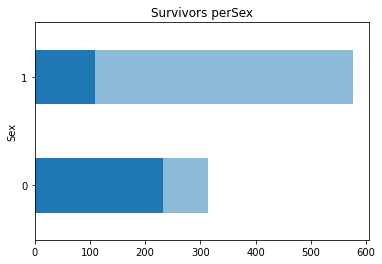

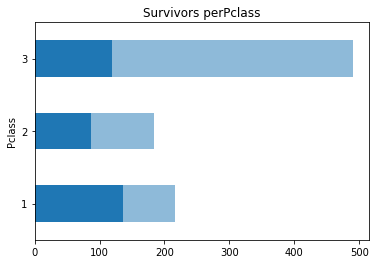

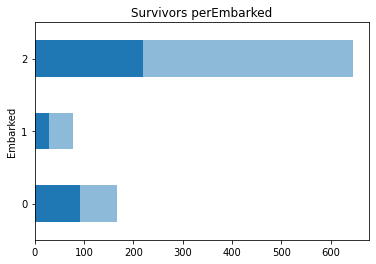

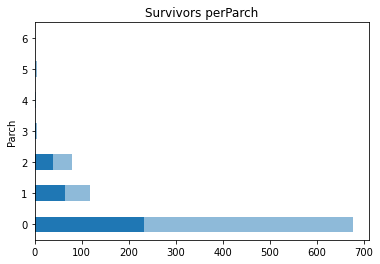

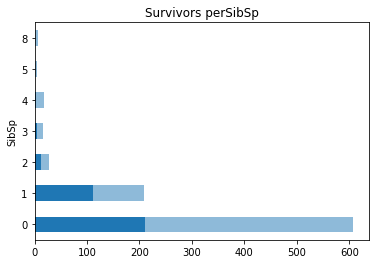

In [9]:
survival_rate("Sex","barh")
survival_rate("Pclass","barh")
survival_rate("Embarked","barh")
survival_rate("Parch","barh")
survival_rate("SibSp","barh")

### model training

In [10]:
from sklearn.model_selection import train_test_split

# Our columns for models building
predictors = ["Pclass","Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

X = df_train[predictors]
y =  df_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=1)

#### Logistic Regression: 

In [11]:
from sklearn.linear_model import  LogisticRegression
clf = LogisticRegression()
clf.fit(X_train,y_train)
print('train accuracy =',clf.score(X_train,y_train))
print('test accuracy =',clf.score(X_test,y_test))

train accuracy = 0.8098802395209581
test accuracy = 0.7937219730941704


Let's visualize the probabilities

In [12]:
pred = pd.DataFrame({
    "Survived_original": y_test,
    "Survived_predicted": clf.predict(X_test),
    "Survived_proba": np.transpose(clf.predict_proba(X_test))[1]
})
pred['Comparison'] = pred['Survived_original'] == pred['Survived_predicted']
pred.head()

,Survived_original,Survived_predicted,Survived_proba,Comparison
862,1,1,0.844338,True
223,0,0,0.090806,True
84,1,1,0.868993,True
680,0,1,0.634029,False
535,1,1,0.919585,True


#### Bagging 

In [13]:
from sklearn.ensemble import BaggingClassifier
clf_log = LogisticRegression(random_state=1)
clf_bag = BaggingClassifier(base_estimator=clf_log, random_state=1, n_estimators=400, max_samples=0.75, max_features=0.85)
clf_bag.fit(X_train,y_train)
print('train accuracy =',clf_bag.score(X_train,y_train))
print('test accuracy =',clf_bag.score(X_test,y_test))

train accuracy = 0.8143712574850299
test accuracy = 0.7892376681614349


#### Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(random_state = 1)
clf_dt.fit(X_train,y_train)
print('train accuracy =',clf_dt.score(X_train,y_train))
print('test accuracy =',clf_dt.score(X_test,y_test))

train accuracy = 0.9895209580838323
test accuracy = 0.7623318385650224


#### Random Forest 

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=1, n_estimators=20)
clf_rf.fit(X_train,y_train)
print('train accuracy =',clf_rf.score(X_train,y_train))
print('test accuracy =',clf_rf.score(X_test,y_test))

train accuracy = 0.9790419161676647
test accuracy = 0.7937219730941704


Text(0.5, 0, 'Number of trees')

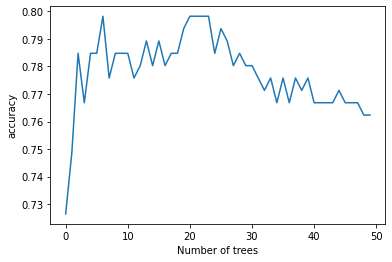

In [16]:
trees = range(50)
accuracy=np.zeros(50)
for index in range(len(trees)):
    clf_rf=RandomForestClassifier(random_state=1,n_estimators=index +1)
    clf_rf.fit(X_train,y_train)
    accuracy[index]=clf_rf.score(X_test,y_test)

plt.plot(trees,accuracy)
plt.ylabel('accuracy')
plt.xlabel('Number of trees')

Let's use Grid search to find the best combination of different of parameters

#### Grid Search

In [17]:
from sklearn.model_selection import GridSearchCV
params = {'min_samples_leaf':list(range(1,5)),'min_samples_split':list(range(2,10,2)),
         'n_estimators':list(range(10,50,10))}
clf_rf2=RandomForestClassifier(random_state=1)
clf_gs=GridSearchCV(clf_rf2,params,scoring='accuracy',cv=5)
clf_gs.fit(X,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [10, 20, 30, 40]},
             scoring='accuracy')

In [18]:
# print the best sore
clf_gs.best_score_

0.8327976900382902

In [19]:
# print the best parameters selected
clf_gs.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 30}

Let'use these best parameters and check wether they achieve the above cv accuracy

In [20]:
clf_rf3 = RandomForestClassifier(random_state=1,min_samples_leaf=3,min_samples_split=8,n_estimators=30)
clf_rf3.fit(X_train,y_train)
print('train accuracy =',clf_rf3.score(X_train,y_train))
print('test accuracy =',clf_rf3.score(X_test,y_test))

from sklearn.model_selection import cross_val_score
scores_rf3 = cross_val_score(clf_rf3,X,y,scoring='accuracy',cv=5)
print("cross validation accuracy =", scores_rf3.mean())

train accuracy = 0.8862275449101796
test accuracy = 0.7802690582959642
cross validation accuracy = 0.8327976900382902


As we can see, grid search allowed us to find the best model parameters to improve our accuracy.
Let's see the most important features of this classifier.

In [21]:
feat_imp = pd.DataFrame(clf_rf3.feature_importances_, predictors, columns=['Importance'])
feat_imp.sort_values('Importance',ascending=False)

,Importance
Sex,0.366855
Fare,0.201260
Age,0.171738
Pclass,0.117001
SibSp,0.061253
Embarked,0.041643
Parch,0.040251


### Predict on TEST DATA 

In [22]:
df_test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [23]:
df_submit = df_test.copy()
df_test = df_test[predictors]
submit_predictions = clf_rf3.predict(df_test)

my_submission = pd.DataFrame({'PassengerId': df_submit.PassengerId, 'Survived': submit_predictions})

### Export data

In [24]:
my_submission.to_csv('submission.csv', index=False)